In [12]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

#Метод градиентного спуска это простой метод для поиска локального минимума функции

class GDRegressor:

    def __init__(self, alpha=0.01, max_iter=100):
        self.alpha = alpha
        self.max_iter = max_iter

    def fit(self, X_train, y_train):  #Обучает модель на данных X_train (матрица признаков) и y_train(вектор ответов).
        if type(X_train) == list:
            pass
        else:
            X_train = X_train.values.tolist()

        if type(y_train) == list:
            pass
        else:
            y_train = y_train.values.tolist()

        X_matrix = []
        for i in range(len(X_train)):
            X_train[i].insert(0, 1)
            X_matrix.append(X_train[i])
        X_as_matrix = np.asmatrix(X_matrix)

        y_matrix = []
        for i in range(len(y_train)):
            y_matrix.append([y_train[i]])

        m = len(y_train)
        self.theta = np.zeros((len(X_matrix[0]), 1))

        for i in range(self.max_iter):
            self.theta = self.theta - self.alpha * (1 / m) * (np.matmul(X_as_matrix.T,
                                                                        (np.matmul(X_matrix, self.theta) - y_matrix)))

        theta_list = np.matrix.tolist(self.theta)
        self.coef_ = theta_list[1:]  # Coef - вектор оценок тетта(i)
        self.intercept_ = theta_list[0]  # Intercept - оцененное значение тетта(0)
        return theta_list
    def predict(self, X_test):  # Возвращение вектора прогнозов для новых данных
        if type(X_test) == list:
            pass
        else:
            X_test = X_test.values.tolist()
        X_matrix_test = []
        for i in range(len(X_test)):
            X_test[i].insert(0, 1)
            X_matrix_test.append(X_test[i])
        answers = np.matmul(X_matrix_test, self.theta)
        return answers

Пример использования

In [2]:
boston = load_boston()
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target
X = data[["RM"]]
y = data["MEDV"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.04, max_iter=2000)
model.fit(X_train, y_train)
answers = model.predict(X_test)
print(model.coef_, model.intercept_)

[[7.075547657596516]] [-21.79244730287655]


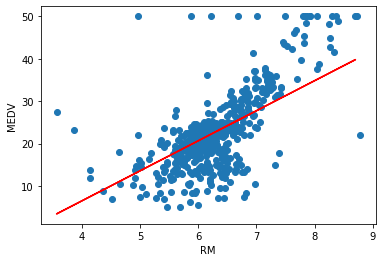

In [4]:
plt.scatter(data["RM"], data["MEDV"])
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.plot(X_train, model.coef_ * X_train + model.intercept_, "r")
plt.show()

Оценка качества модели

In [5]:
def rmse(y_hat, y):  # Отклонение реальных данных от линии регрессии
    """ Root mean squared error """
    if type(y) == list:
        pass
    else:
        y = y.values.tolist()
    m = len(y)
    sum = 0
    for i in range(m):
        sum += ((y_hat[i] - y[i]) ** 2 / m)
    error = np.sqrt(sum)
    return error


def r_squared(y_hat, y):  # Коэффициент детерминации (доля дисперсии зависимой переменной)
    """ R-squared score """
    if type(y) == list:
        pass
    else:
        y = y.values.tolist()
    m = len(y)
    y_avg = np.average(y)

    a = b = 0
    for i in range(m):
        a += (y[i] - y_hat[i]) ** 2
        b += (y[i] - y_avg) ** 2
    error = 1 - a / b
    return error

In [6]:
rmse_value = rmse(answers, y_test)
r_squared = r_squared(answers, y_test)
print("RMSE = ",rmse_value)
print("R_SQUARED = ",r_squared)

RMSE =  [[6.50025692]]
R_SQUARED =  [[0.48822629]]


Найдем оптимальные значения alpha и количества итераций

In [7]:
def plot_cost_function(X, y, estimator=None, max_iters=100, eta0=0.01, params=None, normalize=False):
    if estimator is SGDRegressor:
        if not params:
            params = {
                "loss": "squared_loss",
                "penalty": "none",
                "learning_rate": "constant",
            }
        else:
            params.update(params)

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=18)

    if normalize:
        X_train = StandardScaler().fit_transform(X_train)
        Y_train = StandardScaler().fit_transform(Y_train.values.reshape(-1, 1))
        X_test = StandardScaler().fit_transform(X_test)
        Y_test = StandardScaler().fit_transform(Y_test.values.reshape(-1, 1))

    cost_history = []
    for it in range(5, max_iters, round(max_iters * 0.01)):
        if estimator is SGDRegressor:
            model = estimator(max_iter=it, eta0=eta0, **params)
        else:
            model = estimator(max_iter=it, alpha=eta0)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        cost_history.append([it, mse])

    iterations, errors = list(zip(*cost_history))
    plt.plot(iterations, errors, "-")
    plt.xlabel("#Iteration")
    plt.ylabel("MSE")
    plt.show()

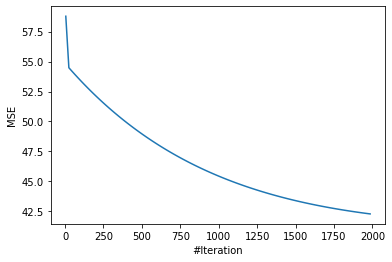

In [8]:
plot_cost_function(X, y, GDRegressor, max_iters=2000, eta0=0.04)

Удаляем значения, при которых MED = 50

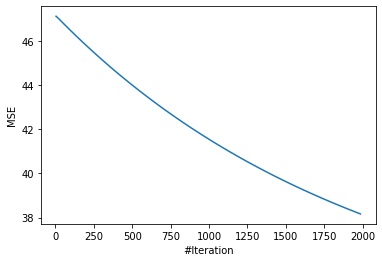

In [9]:
X_filtered = data[(data["MEDV"] < 50)][["RM"]]
y_filtered = data[(data["MEDV"] < 50)]["MEDV"]
plot_cost_function(X_filtered, y_filtered, GDRegressor, max_iters=2000, eta0=0.03)

Нормализация значений

In [10]:
def z_scaler(feature):
    return (feature - feature.mean()) / feature.std()

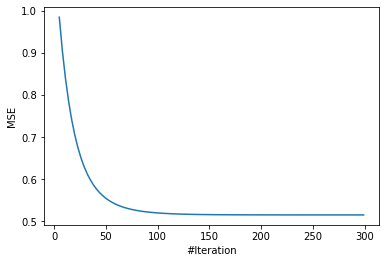

In [11]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)
plot_cost_function(X_scaled, y_scaled, GDRegressor, max_iters=300, eta0=0.04)